In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('mm_data.csv')

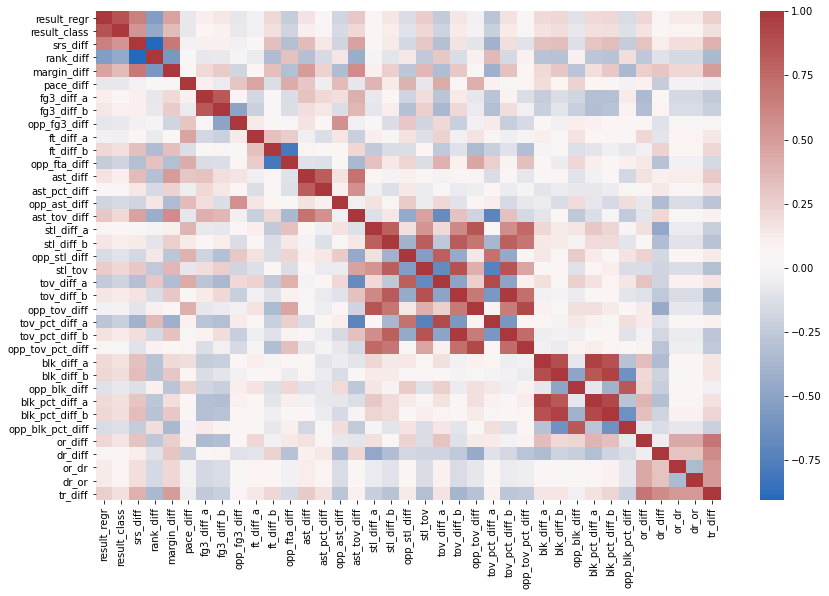

In [3]:
corr = df.corr('spearman')
fig = plt.figure(figsize=(14,9))
_ = sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, cmap='vlag')

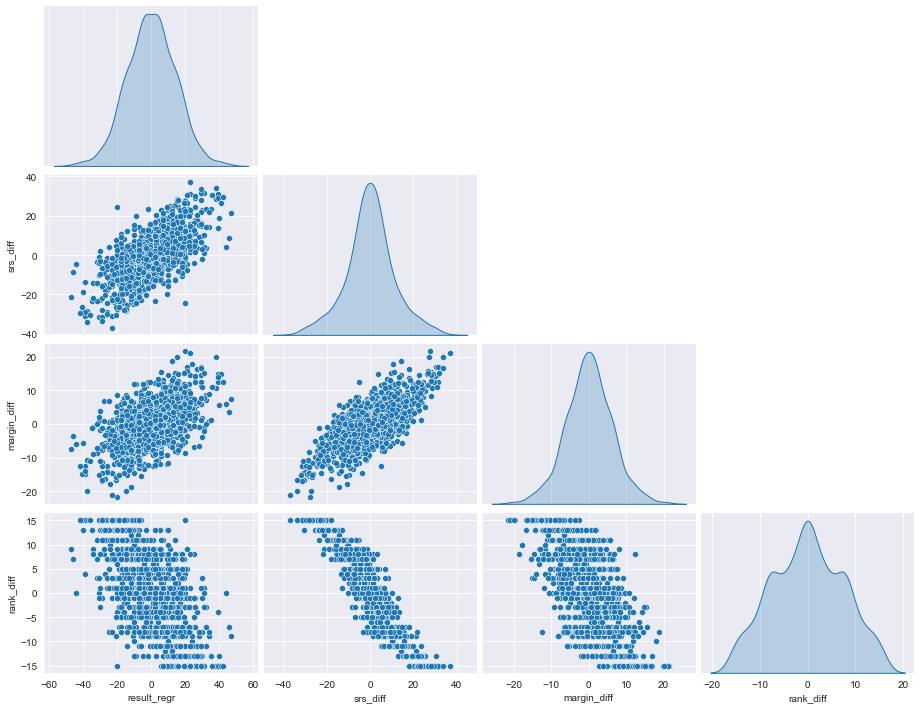

In [4]:
sns.set_style('darkgrid')
# _ = plt.scatter(df['srs_diff'], df['result_regr'], marker='+', alpha=0.4)
# _ = sns.scatterplot('srs_diff', 'result_regr', data=df, alpha=0.4)
_ = sns.pairplot(df[['result_regr','srs_diff','margin_diff','rank_diff']], corner=True, diag_kind='kde', aspect=1.3)

### Prepwork for all classification techniques

In [5]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score, make_scorer

scoring = {'Accuracy': make_scorer(accuracy_score),
           'AUC': make_scorer(roc_auc_score)}

Y_cv = df['result_class']
X_cv = df.drop(columns=['result_class','result_regr'])
X_cv.shape

(1334, 35)

### Dummy Classifier
#### Higher-ranked team predicted as victor; ties settled by margin_diff

In [6]:
dummy_clf = df['rank_diff'].apply(lambda x: 1 if x<0 else (0 if x>0 else -1))
backup = df['margin_diff'].apply(lambda x: 1 if x>0 else 0)
dummy_clf[dummy_clf < 0] = backup[dummy_clf < 0]

In [7]:
print('Dummy Classifier:  Accuracy = ' + str(np.round(accuracy_score(Y_cv, dummy_clf),3)) + \
       ';  AUC = ' + str(np.round(roc_auc_score(Y_cv, dummy_clf),3)))

Dummy Classifier:  Accuracy = 0.687;  AUC = 0.687


### Gradient Boosted Tree Classification

In [8]:
from sklearn.ensemble import GradientBoostingClassifier

In [9]:
parameters = {
    "learning_rate" : [0.006, 0.0125, 0.025, 0.05, 0.1],  # Shrinkage parameter to prevent over-fitting (default = 0.1)
    "max_depth" : [1, 2, 3],  # Maximum depth of individual trees (default = 3)
    "n_estimators" : [10, 20, 40, 70, 100],  # Number of boosting stages (default = 100)
    }
clf = GridSearchCV(GradientBoostingClassifier(random_state=321), param_grid=parameters, scoring=scoring, cv=5, refit=False, n_jobs=-1)
clf.fit(X_cv, Y_cv)
cv_out = pd.DataFrame.from_dict(clf.cv_results_).sort_values(['rank_test_Accuracy','rank_test_AUC']).rename(
    columns={'param_learning_rate':'learning_rate', 'param_max_depth':'max_depth', 'param_n_estimators':'n_estimators'})

# display Top 10 hyperparameter combinations
cv_out.iloc[0:10,:][['learning_rate', 'max_depth', 'n_estimators', 
                      'mean_test_Accuracy', 'mean_test_AUC', 'rank_test_Accuracy', 'rank_test_AUC']]

,learning_rate,max_depth,n_estimators,mean_test_Accuracy,mean_test_AUC,rank_test_Accuracy,rank_test_AUC
17,0.0125,1,40,0.727859,0.728078,1,1
47,0.05,1,40,0.727859,0.728078,1,1
50,0.05,2,10,0.727859,0.728078,1,1
45,0.05,1,10,0.727110,0.727337,4,4
46,0.05,1,20,0.727110,0.727337,4,4
1,0.006,1,20,0.725612,0.725822,6,6
2,0.006,1,40,0.725612,0.725822,6,6
3,0.006,1,70,0.725612,0.725822,6,6
4,0.006,1,100,0.725612,0.725822,6,6
5,0.006,2,10,0.725612,0.725822,6,6


In [10]:
print('Gradient Boosted Tree:  Accuracy = ' + str(np.round(cv_out['mean_test_Accuracy'].iloc[0], 3)) + \
       ';  AUC = ' + str(np.round(cv_out['mean_test_AUC'].iloc[0], 3)))
print('    learning rate = 0.05;  max_depth = 1;  n_estimators = 40')

Gradient Boosted Tree:  Accuracy = 0.728;  AUC = 0.728
    learning rate = 0.05;  max_depth = 1;  n_estimators = 40


In [11]:
gbc = GradientBoostingClassifier(learning_rate=0.05, max_depth=1, n_estimators=40, random_state=321)
gbc.fit(X_cv, Y_cv)
feature_importances = pd.DataFrame({'feature':X_cv.columns, 'importance':gbc.feature_importances_}).sort_values(
    by='importance', ascending=False)
feature_importances.iloc[0:10]

,feature,importance
0,srs_diff,1.0
26,opp_blk_diff,0.0
20,opp_tov_diff,0.0
21,tov_pct_diff_a,0.0
22,tov_pct_diff_b,0.0
23,opp_tov_pct_diff,0.0
24,blk_diff_a,0.0
25,blk_diff_b,0.0
27,blk_pct_diff_a,0.0
18,tov_diff_a,0.0


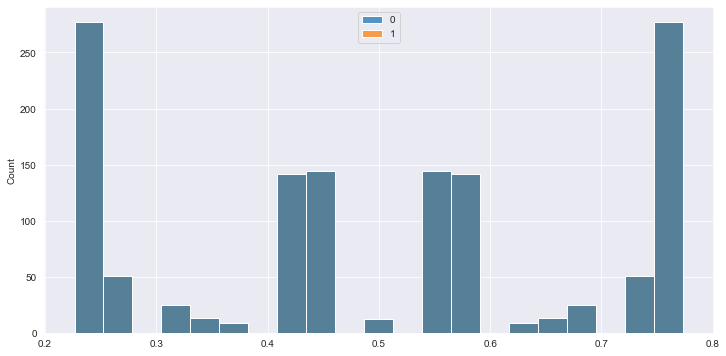

In [24]:
gbc_probs = gbc.predict_proba(X_cv)
fig = plt.figure(figsize=(12,6))
_ = sns.histplot(gbc_probs, bins=21)

### Random Forest Classification

In [13]:
from sklearn.ensemble import RandomForestClassifier

In [14]:
parameters = {
    "max_features" : [6, 8, 10, 12],  # Number of features considered at each split (default = sqrt(p))
    "min_samples_leaf" : [1, 2, 3, 4],  # Minimum number of samples per leaf (default = 1)
    "n_estimators" : [400],  # Number of trees in forest (default = 100)
    }
clf = GridSearchCV(RandomForestClassifier(random_state=321), param_grid=parameters, scoring=scoring, cv=5, refit=False, n_jobs=-1)
clf.fit(X_cv, Y_cv)
cv_out = pd.DataFrame.from_dict(clf.cv_results_).sort_values(['rank_test_Accuracy','rank_test_AUC']).rename(
    columns={'param_max_features':'max_features', 'param_min_samples_leaf':'min_samples_leaf', 'param_n_estimators':'n_estimators'})

# display Top 10 hyperparameter combinations
cv_out.iloc[0:10,:][['max_features', 'min_samples_leaf', 'n_estimators', 
                      'mean_test_Accuracy', 'mean_test_AUC', 'rank_test_Accuracy', 'rank_test_AUC']]

,max_features,min_samples_leaf,n_estimators,mean_test_Accuracy,mean_test_AUC,rank_test_Accuracy,rank_test_AUC
9,10,2,400,0.679871,0.680266,1,1
7,8,4,400,0.679130,0.679559,2,2
11,10,4,400,0.679128,0.679514,3,4
4,8,1,400,0.679116,0.679525,4,3
15,12,4,400,0.678379,0.678757,5,6
5,8,2,400,0.678373,0.678807,6,5
0,6,1,400,0.676878,0.677286,7,7
6,8,3,400,0.675377,0.675766,8,8
13,12,2,400,0.674630,0.675042,9,9
8,10,1,400,0.674630,0.675031,9,10


In [15]:
print('Random Forest:  Accuracy = ' + str(np.round(cv_out['mean_test_Accuracy'].iloc[0], 3)) + \
       ';  AUC = ' + str(np.round(cv_out['mean_test_AUC'].iloc[0], 3)))
print('    max_features = 10;  min_samples_leaf = 2;  n_estimators = 400')

Random Forest:  Accuracy = 0.68;  AUC = 0.68
    max_features = 10;  min_samples_leaf = 2;  n_estimators = 400


In [16]:
rfc = RandomForestClassifier(max_features=10, min_samples_leaf=2, n_estimators=400, random_state=321)
rfc.fit(X_cv, Y_cv)
feature_importances = pd.DataFrame({'feature':X_cv.columns, 'importance':rfc.feature_importances_}).sort_values(
    by='importance', ascending=False)
feature_importances.iloc[0:10]

,feature,importance
0,srs_diff,0.212149
1,rank_diff,0.082846
2,margin_diff,0.047775
11,ast_pct_diff,0.029906
17,stl_tov,0.027583
6,opp_fg3_diff,0.025880
9,opp_fta_diff,0.023718
3,pace_diff,0.023523
7,ft_diff_a,0.023482
12,opp_ast_diff,0.022605


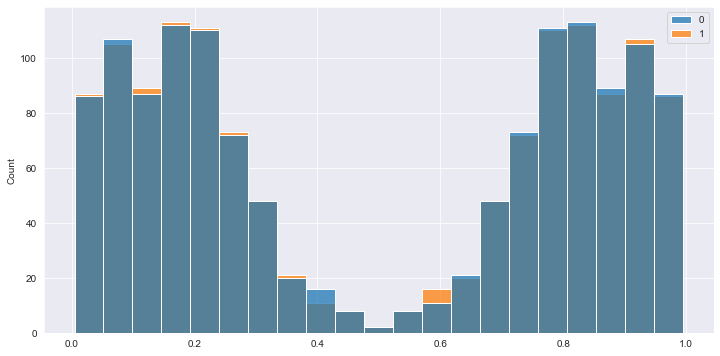

In [25]:
rfc_probs = rfc.predict_proba(X_cv)
fig = plt.figure(figsize=(12,6))
_ = sns.histplot(rfc_probs, bins=21)

### Decision Tree Classification

In [18]:
from sklearn.tree import DecisionTreeClassifier

In [19]:
samples = [x+1 for x in list(range(50))]
parameters = {
    "min_samples_leaf" : samples,  # Minimum number of samples per leaf (default = 1)
    }
clf = GridSearchCV(DecisionTreeClassifier(random_state=321), param_grid=parameters, scoring=scoring, cv=5, refit=False, n_jobs=-1)
clf.fit(X_cv, Y_cv)
cv_out = pd.DataFrame.from_dict(clf.cv_results_).sort_values(['rank_test_Accuracy','rank_test_AUC']).rename(
    columns={'param_min_samples_leaf':'min_samples_leaf'})

# display Top 10 hyperparameter combinations
cv_out.iloc[0:10,:][['min_samples_leaf', 'mean_test_Accuracy', 'mean_test_AUC', 'rank_test_Accuracy', 'rank_test_AUC']]

,min_samples_leaf,mean_test_Accuracy,mean_test_AUC,rank_test_Accuracy,rank_test_AUC
21,22,0.694112,0.694338,1,1
13,14,0.691893,0.692094,2,2
20,21,0.691867,0.692094,3,3
39,40,0.690372,0.690674,4,4
14,15,0.689645,0.689866,5,6
47,48,0.689640,0.689967,6,5
29,30,0.689629,0.689838,7,7
27,28,0.689626,0.689833,8,8
28,29,0.688871,0.689053,9,9
35,36,0.688122,0.688391,10,10


In [20]:
print('Decision Tree:  Accuracy = ' + str(np.round(cv_out['mean_test_Accuracy'].iloc[0], 3)) + \
       ';  AUC = ' + str(np.round(cv_out['mean_test_AUC'].iloc[0], 3)))
print('    min_samples_leaf = 22')

Decision Tree:  Accuracy = 0.694;  AUC = 0.694
    min_samples_leaf = 22


In [21]:
dtc = DecisionTreeClassifier(min_samples_leaf=22, random_state=321)
dtc.fit(X_cv, Y_cv)
feature_importances = pd.DataFrame({'feature':X_cv.columns, 'importance':dtc.feature_importances_}).sort_values(
    by='importance', ascending=False)
feature_importances.iloc[0:10]

,feature,importance
0,srs_diff,0.659507
3,pace_diff,0.073684
6,opp_fg3_diff,0.054436
14,stl_diff_a,0.039703
7,ft_diff_a,0.028918
11,ast_pct_diff,0.026773
12,opp_ast_diff,0.026222
34,tr_diff,0.022436
2,margin_diff,0.016792
33,dr_or,0.015813


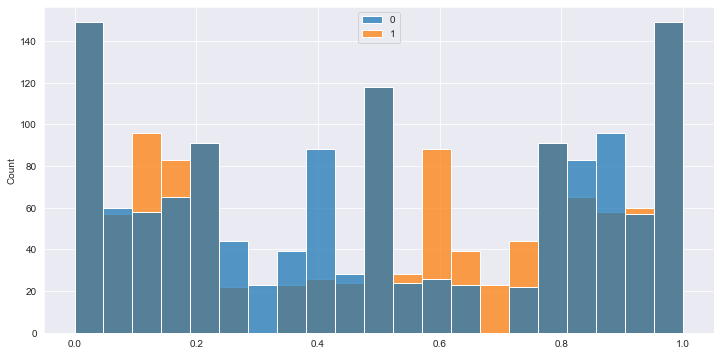

In [23]:
dtc_probs = dtc.predict_proba(X_cv)
fig = plt.figure(figsize=(12,6))
_ = sns.histplot(dtc_probs, bins=21)

### Logistic Regression

In [26]:
from sklearn.linear_model import LogisticRegression

In [27]:
parameters = {
    "l1_ratio" : [0, 0.125, 0.25, 0.375, 0.5, 0.625, 0.75, 0.875, 1],  # 1 = l1 regularization only; 0 = l2 regularization only
    "C" : [0.006, 0.0125, 0.025, 0.05, 0.1, 0.2],  # Regularization parameter (default = 1)
    "fit_intercept" : [False],  # Include intercept or not (default = True)
    "penalty" : ['elasticnet'],  # Regularization penalty type
    "solver" : ['saga'],  # Optimization algorithm
    "max_iter" : [400]  # Max number iterations for optimization algorithm
    }
clf = GridSearchCV(LogisticRegression(random_state=321), param_grid=parameters, scoring=scoring, cv=5, refit=False, n_jobs=-1)
clf.fit(X_cv, Y_cv)
cv_out = pd.DataFrame.from_dict(clf.cv_results_).sort_values(['rank_test_Accuracy','rank_test_AUC']).rename(
    columns={'param_l1_ratio':'l1_ratio', 'param_C':'C', 'param_fit_intercept':'fit_intercept'})

# display Top 10 hyperparameter combinations
cv_out.iloc[0:10,:][['l1_ratio', 'C', 'fit_intercept', 
                      'mean_test_Accuracy', 'mean_test_AUC', 'rank_test_Accuracy', 'rank_test_AUC']]

,l1_ratio,C,fit_intercept,mean_test_Accuracy,mean_test_AUC,rank_test_Accuracy,rank_test_AUC
31,0.5,0.05,False,0.740596,0.740820,1,1
44,1,0.1,False,0.740596,0.740820,2,1
34,0.875,0.05,False,0.739847,0.740063,3,5
32,0.625,0.05,False,0.739844,0.740068,4,3
33,0.75,0.05,False,0.739844,0.740068,4,3
10,0.125,0.0125,False,0.739844,0.740063,4,6
20,0.25,0.025,False,0.739095,0.739322,7,8
21,0.375,0.025,False,0.739095,0.739317,7,9
43,0.875,0.1,False,0.739095,0.739328,9,7
0,0,0.006,False,0.738349,0.738593,10,10


In [28]:
print('Logistic Regression:  Accuracy = ' + str(np.round(cv_out['mean_test_Accuracy'].iloc[0], 3)) + \
       ';  AUC = ' + str(np.round(cv_out['mean_test_AUC'].iloc[0], 3)))
print('    l1_ratio = 0.5;  C = 0.05;  fit_intercept = False;  penalty = "elasticnet";  solver = "saga";  max_iter = 400')

Logistic Regression:  Accuracy = 0.741;  AUC = 0.741
    l1_ratio = 0.5;  C = 0.05;  fit_intercept = False;  penalty = "elasticnet";  solver = "saga";  max_iter = 400


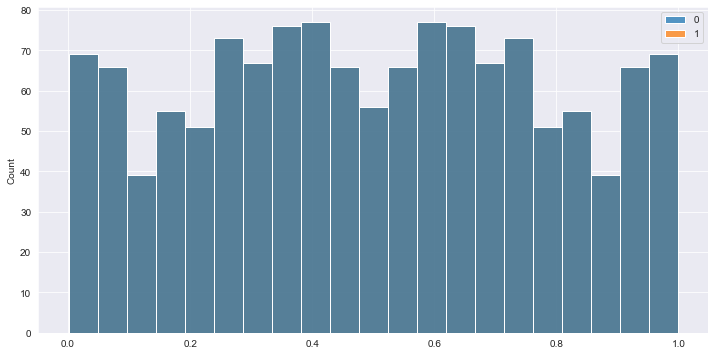

In [29]:
lrc = LogisticRegression(l1_ratio=0.5, C=0.05, fit_intercept=False, penalty="elasticnet", solver="saga", max_iter=400, random_state=321)
lrc.fit(X_cv, Y_cv)
lrc_probs = lrc.predict_proba(X_cv)
fig = plt.figure(figsize=(12,6))
_ = sns.histplot(lrc_probs, bins=21)

#### Dummy Regressor
##### Simple linear regression with srs_diff

In [ ]:
from sklearn import linear_model
from sklearn.model_selection import cross_validate
from sklearn.metrics import r2_score

dummy_reg_cv = cross_validate(linear_model.LinearRegression(fit_intercept=False), 
                              np.array(df['srs_diff']).reshape(-1,1), y=df['result_regr'], 
                              scoring=['r2','neg_mean_absolute_error'], return_estimator=True)

In [ ]:
print('Cross-Validated Stats: R2 =', np.round(dummy_reg_cv['test_r2'].mean(), 3), 
      ';  MAE =', np.round(dummy_reg_cv['test_neg_mean_absolute_error'].mean(), 2))

In [ ]:
fig = plt.figure(figsize=(12,9))
_ = plt.scatter(df['srs_diff'], df['result_regr'],  color='black', alpha=0.2)
_ = plt.plot(df['srs_diff'], dummy_reg_cv['estimator'][0].predict(np.array(df['srs_diff']).reshape(-1,1)), color='red', linewidth=0.25)
_ = plt.plot(df['srs_diff'], dummy_reg_cv['estimator'][1].predict(np.array(df['srs_diff']).reshape(-1,1)), color='red', linewidth=0.25)
_ = plt.plot(df['srs_diff'], dummy_reg_cv['estimator'][2].predict(np.array(df['srs_diff']).reshape(-1,1)), color='red', linewidth=0.25)
_ = plt.plot(df['srs_diff'], dummy_reg_cv['estimator'][3].predict(np.array(df['srs_diff']).reshape(-1,1)), color='red', linewidth=0.25)
_ = plt.plot(df['srs_diff'], dummy_reg_cv['estimator'][4].predict(np.array(df['srs_diff']).reshape(-1,1)), color='red', linewidth=0.25)